In [102]:
import pandas as pd
import geopandas as gpd
import numpy as np
import re
from shapely.geometry import MultiPolygon, Polygon, Point
from sklearn.cluster import KMeans
from geopy.distance import distance
from ast import literal_eval
import math 
from geopy.distance import distance
import pyproj
import matplotlib.pyplot as plt 

In [2]:
def plot_data(df):
    
    # Separate x and y values from the coordinate tuples
    x_values = []
    y_values = []

    for index, row in df.iterrows():
        x_values.append([row['Location'][0]])
        y_values.append([row['Location'][1]])


    # Create a scatter plot
    plt.scatter(x_values, y_values)

    # Add axis labels
    plt.xlabel('X')
    plt.ylabel('Y')

    # Show the plot
    plt.show()

In [3]:
df = pd.read_csv('SivuvirtaOlki2021.csv',header=0,sep=';')
df

,Year,Type,Mass,Area
0,2021,Sivuvirta: Olki,5.667554,"MULTIPOLYGON (((279000 6639000, 278000 6639000..."
1,2021,Sivuvirta: Olki,171.175036,"MULTIPOLYGON (((213000 6735000, 212000 6735000..."
2,2021,Sivuvirta: Olki,95.572340,"MULTIPOLYGON (((212000 6735000, 211000 6735000..."
3,2021,Sivuvirta: Olki,65.310390,"MULTIPOLYGON (((211000 6735000, 210000 6735000..."
4,2021,Sivuvirta: Olki,29.159215,"MULTIPOLYGON (((210000 6735000, 209000 6735000..."
...,...,...,...,...
78641,2021,Sivuvirta: Olki,0.181156,"MULTIPOLYGON (((309000 6641000, 308000 6641000..."
78642,2021,Sivuvirta: Olki,6.376281,"MULTIPOLYGON (((283000 6640000, 282000 6640000..."
78643,2021,Sivuvirta: Olki,9.969457,"MULTIPOLYGON (((282000 6640000, 281000 6640000..."
78644,2021,Sivuvirta: Olki,1.332805,"MULTIPOLYGON (((279000 6640000, 278000 6640000..."


In [4]:
# Formatting the data

# define the regex pattern
#pattern = r'\d+\.\d+\s\d+\.\d+'
pattern = re.compile(r"MULTIPOLYGON \(\(\([^)]*\)\)\)", re.IGNORECASE)

coords = df['Area'][1]

coords = coords.replace('(','')
coords = coords.replace(')','')
coords = coords.replace('MULTIPOLYGON','')
coords = coords.strip()
coords = coords.split(', ')
for index1, row in df.iterrows():
    input_string = df['Area'][index1]
    input_string = input_string.replace('(','')
    input_string = input_string.replace(')','')
    input_string = input_string.replace('MULTIPOLYGON','')
    input_string = input_string.strip()
    coordinates = input_string.split(', ')
    for index2, coordinate in enumerate(coordinates):
        df.loc[index1,'Coordinate '+ str(index2)]=coordinate
df

,Year,Type,Mass,Area,Coordinate 0,Coordinate 1,Coordinate 2,Coordinate 3,Coordinate 4
0,2021,Sivuvirta: Olki,5.667554,"MULTIPOLYGON (((279000 6639000, 278000 6639000...",279000 6639000,278000 6639000,278000 6640000,279000 6640000,279000 6639000
1,2021,Sivuvirta: Olki,171.175036,"MULTIPOLYGON (((213000 6735000, 212000 6735000...",213000 6735000,212000 6735000,212000 6736000,213000 6736000,213000 6735000
2,2021,Sivuvirta: Olki,95.572340,"MULTIPOLYGON (((212000 6735000, 211000 6735000...",212000 6735000,211000 6735000,211000 6736000,212000 6736000,212000 6735000
3,2021,Sivuvirta: Olki,65.310390,"MULTIPOLYGON (((211000 6735000, 210000 6735000...",211000 6735000,210000 6735000,210000 6736000,211000 6736000,211000 6735000
4,2021,Sivuvirta: Olki,29.159215,"MULTIPOLYGON (((210000 6735000, 209000 6735000...",210000 6735000,209000 6735000,209000 6736000,210000 6736000,210000 6735000
...,...,...,...,...,...,...,...,...,...
78641,2021,Sivuvirta: Olki,0.181156,"MULTIPOLYGON (((309000 6641000, 308000 6641000...",309000 6641000,308000 6641000,308000 6642000,309000 6642000,309000 6641000
78642,2021,Sivuvirta: Olki,6.376281,"MULTIPOLYGON (((283000 6640000, 282000 6640000...",283000 6640000,282000 6640000,282000 6641000,283000 6641000,283000 6640000
78643,2021,Sivuvirta: Olki,9.969457,"MULTIPOLYGON (((282000 6640000, 281000 6640000...",282000 6640000,281000 6640000,281000 6641000,282000 6641000,282000 6640000
78644,2021,Sivuvirta: Olki,1.332805,"MULTIPOLYGON (((279000 6640000, 278000 6640000...",279000 6640000,278000 6640000,278000 6641000,279000 6641000,279000 6640000


In [5]:
# Calculate the mean points of biomass potentials and replace the coordinates with them

# Coordinate 4 is not included, since Coordinate 0 = Coordinate 4
df2 = df[['Coordinate 0','Coordinate 1','Coordinate 2','Coordinate 3']]
meanpoints = []

for index1, row in df2.iterrows():
    x = 0
    y = 0
    for index2, coordinate in enumerate(row):
        coordinate = coordinate.split(' ')
        #x += float(coordinate[0])/10000
       # y += float(coordinate[1])/100000
        x += float(coordinate[0])
        y += float(coordinate[1])
    meanpoints.append(tuple((x/4,y/4)))

In [6]:
# Clean the dataframe
df['Location']=meanpoints
df = df.drop(['Area','Coordinate 0','Coordinate 1','Coordinate 2','Coordinate 3','Coordinate 4'],axis=1)
df

,Year,Type,Mass,Location
0,2021,Sivuvirta: Olki,5.667554,"(278500.0, 6639500.0)"
1,2021,Sivuvirta: Olki,171.175036,"(212500.0, 6735500.0)"
2,2021,Sivuvirta: Olki,95.572340,"(211500.0, 6735500.0)"
3,2021,Sivuvirta: Olki,65.310390,"(210500.0, 6735500.0)"
4,2021,Sivuvirta: Olki,29.159215,"(209500.0, 6735500.0)"
...,...,...,...,...
78641,2021,Sivuvirta: Olki,0.181156,"(308500.0, 6641500.0)"
78642,2021,Sivuvirta: Olki,6.376281,"(282500.0, 6640500.0)"
78643,2021,Sivuvirta: Olki,9.969457,"(281500.0, 6640500.0)"
78644,2021,Sivuvirta: Olki,1.332805,"(278500.0, 6640500.0)"


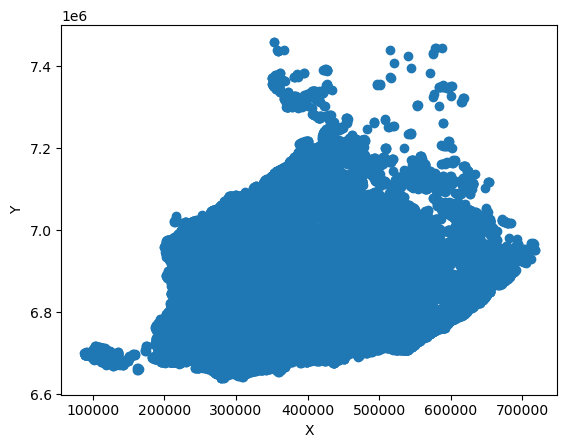

In [7]:
plot_data(df)

In [8]:
# Clean the data from the rows that are further away than 50 km from the Envor's facility. 
# Estimate for the biogas facility location:

# Define the WGS84 and EUREF-FIN coordinate systems
wgs84 = pyproj.CRS('EPSG:4326')
euref_fin = pyproj.CRS('EPSG:3067')

#lat, lon = 60.926203,23.371435
lat, lon = 60.929833, 23.369694  # in decimal degrees

transformer = pyproj.Transformer.from_crs(wgs84, euref_fin, always_xy=True)
euref_x, euref_y = transformer.transform(lon, lat)

FACILITY_LOC = (euref_x, euref_y)
print(FACILITY_LOC)
GREATEST_DISTANCE = 50

rowsToDelete = [0] * df.shape[0]

for index, row in df.iterrows():
    #distanceToFac = distance(FACILITY_LOC,row['Location']).km does not work with EUREF-FIN coordinates
    distanceToFac = math.sqrt(pow(FACILITY_LOC[0]-row['Location'][0],2)+pow(FACILITY_LOC[1]-row['Location'][1],2))/1000
    if distanceToFac > GREATEST_DISTANCE:
        rowsToDelete[index]=1


(303288.4204125573, 6760421.399569039)


In [9]:
bool_series = pd.Series(rowsToDelete, dtype=bool)
df = df[~bool_series]

rowsToDelete
df

,Year,Type,Mass,Location
166,2021,Sivuvirta: Olki,0.880735,"(345500.0, 6734500.0)"
167,2021,Sivuvirta: Olki,0.704648,"(344500.0, 6734500.0)"
168,2021,Sivuvirta: Olki,48.168853,"(334500.0, 6734500.0)"
169,2021,Sivuvirta: Olki,12.519086,"(333500.0, 6734500.0)"
170,2021,Sivuvirta: Olki,9.030584,"(332500.0, 6734500.0)"
...,...,...,...,...
71035,2021,Sivuvirta: Olki,33.390363,"(304500.0, 6710500.0)"
71036,2021,Sivuvirta: Olki,54.179336,"(303500.0, 6710500.0)"
71037,2021,Sivuvirta: Olki,67.047351,"(302500.0, 6710500.0)"
71038,2021,Sivuvirta: Olki,139.271744,"(301500.0, 6710500.0)"


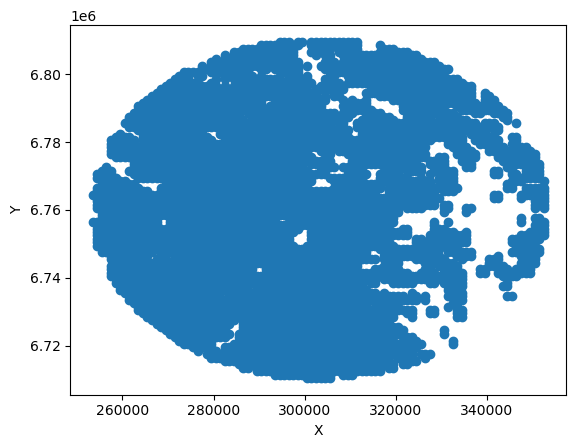

In [10]:
plot_data(df)

In [11]:
# Clustering the data with K-means. Utilzing the elbow method to decide optimal value for k.
# The basic idea in elbow method is to plot the within-cluster 
# sum of squares (WCSS) against the number of clusters, and choose the number of clusters 
# at the "elbow" point where the rate of decrease in WCSS slows down significantly.

k_vals = list(range(1,100))
wcss = []
labels=[]
locations = df['Location'].tolist()
locations = np.array(locations)

# MASSOJEN JAKAUMAN HUOMIOIMINEN KLUSTEROINNISSA ???

for i in k_vals:    
    kmeans = KMeans(n_clusters=i,n_init='auto')
    kmeans.fit(locations)
    wcss.append(kmeans.inertia_)
    labels.append(kmeans.predict(locations))


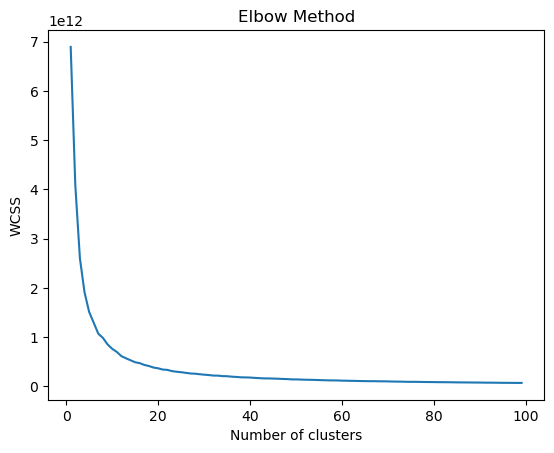

In [12]:
# Plot the WCSS values against the number of clusters
plt.plot(range(1, 100), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

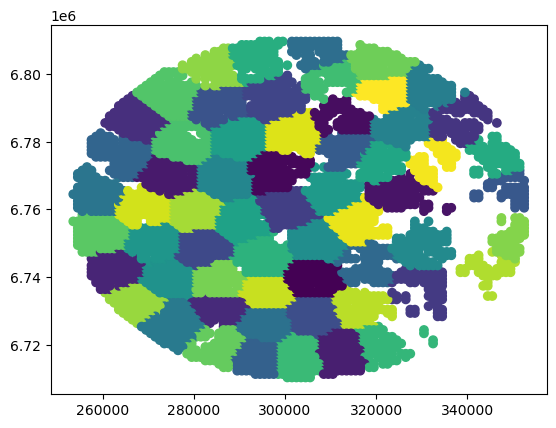

In [13]:
# Based on the graph above, close to optimal and good enough k-values for this datasets is 60.
# Let's plot the data with 60 clusters.
# Plotting the data

KCLUSTERS = 60

plt.scatter(locations[:,0],locations[:,1],c=labels[KCLUSTERS-1])

In [14]:
kmeans = KMeans(n_clusters=KCLUSTERS,n_init='auto')
kmeans.fit(locations)

df['Cluster'] = kmeans.predict(locations)
df

C:\Users\K-A-S\AppData\Local\Temp\ipykernel_3660\2301283388.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster'] = kmeans.predict(locations)


,Year,Type,Mass,Location,Cluster
166,2021,Sivuvirta: Olki,0.880735,"(345500.0, 6734500.0)",5
167,2021,Sivuvirta: Olki,0.704648,"(344500.0, 6734500.0)",5
168,2021,Sivuvirta: Olki,48.168853,"(334500.0, 6734500.0)",52
169,2021,Sivuvirta: Olki,12.519086,"(333500.0, 6734500.0)",52
170,2021,Sivuvirta: Olki,9.030584,"(332500.0, 6734500.0)",52
...,...,...,...,...,...
71035,2021,Sivuvirta: Olki,33.390363,"(304500.0, 6710500.0)",34
71036,2021,Sivuvirta: Olki,54.179336,"(303500.0, 6710500.0)",43
71037,2021,Sivuvirta: Olki,67.047351,"(302500.0, 6710500.0)",43
71038,2021,Sivuvirta: Olki,139.271744,"(301500.0, 6710500.0)",43


In [15]:
# TODO Calculate weighted mean points of the clusters, include mass in the mean-calculation

In [16]:
# Getting masses and locations for each cluster

cluster_masses = [[] for _ in range(KCLUSTERS)]
cluster_locations = [[] for _ in range(KCLUSTERS)]

for index, row in df.iterrows():
    cluster_masses[row['Cluster']].append(row['Mass'])
    cluster_locations[row['Cluster']].append(row['Location'])


In [71]:
sum(cluster_masses[4])
print(sum(cluster_masses[1]))

9197.880801461795


In [76]:
# Calculate the weighted average centroid for clusters:

weighted_avg_centroids = []
sum_cluster_masses = []

for i in range(KCLUSTERS):
    sum_x = sum([mass * loc[0] for mass, loc in zip(cluster_masses[i], cluster_locations[i])])
    sum_y = sum([mass * loc[1] for mass, loc in zip(cluster_masses[i], cluster_locations[i])])
    weighted_avg_centroids.append((sum_x / sum(cluster_masses[i]), sum_y / sum(cluster_masses[i])))
    sum_cluster_masses.append(sum(cluster_masses[i]))


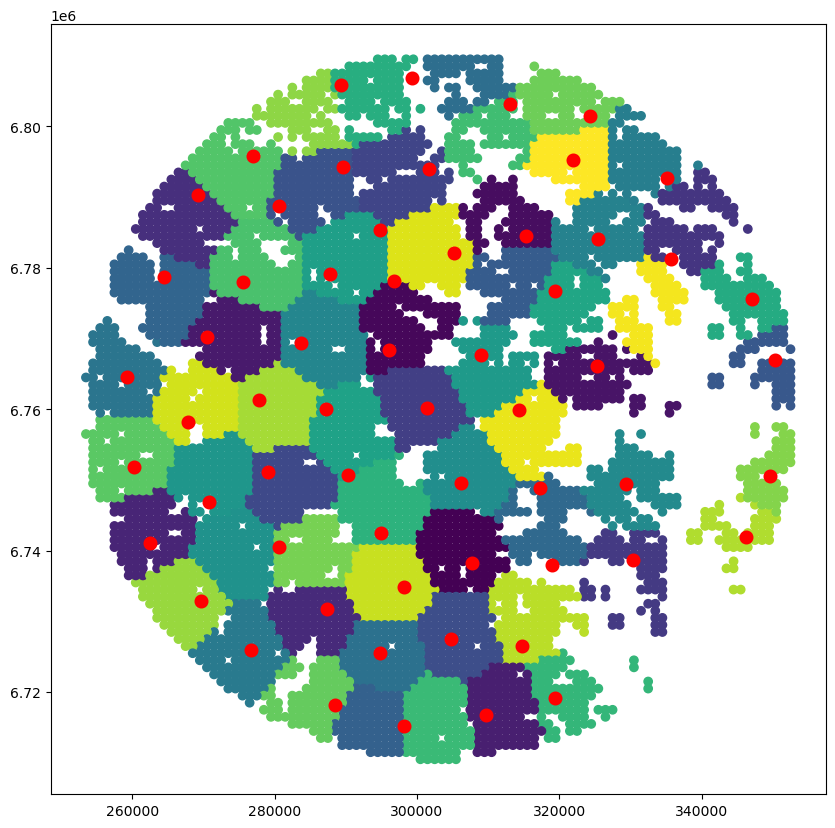

In [77]:
# Plotting the data with the centroids:

fig, ax = plt.subplots(figsize=(10,10))  # set the initial size to 8x8 inches

# scatter plot of data points and their clusters
plt.scatter(locations[:, 0], locations[:, 1], c=labels[KCLUSTERS-1])

# scatter plot of cluster centroids
centroids = np.array(weighted_avg_centroids)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='.', s=200, linewidths=3, color='red')

plt.show()  # show the plot


# Color the cluster based on their masses to see the distribution of masses

# NÄMÄ TÄYTYY SAADA GEOJSON-muotoon, NYT VIEDÄÄN VAIN CSV.

In [78]:
df = pd.DataFrame({'ClusterLocations': weighted_avg_centroids, 'Clustermasses': sum_cluster_masses}, index=range(1, len(weighted_avg_centroids)+1))


In [79]:
df

,ClusterLocations,Clustermasses
1,"(280677.72515075543, 6788778.915270396)",6391.360961
2,"(298238.2030155584, 6734820.504510791)",9197.880801
3,"(335648.60419427045, 6781315.633524607)",3983.595881
4,"(267865.55709423026, 6758180.973428657)",10237.911689
5,"(305233.9033011067, 6782161.061707956)",3176.699710
6,"(346311.36040634563, 6742004.228636731)",742.572411
7,"(294886.1530054955, 6725548.911746968)",8173.302173
8,"(280653.7358788891, 6740472.3691251995)",12717.108668
9,"(314288.6641523004, 6759837.4753415715)",5923.459527
10,"(321941.5424352267, 6795289.166973411)",3528.838889


In [90]:
# define the ETRS-TM35FIN projection
etrs_tm35fin = pyproj.Proj("+proj=utm +zone=35 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs")

# define a function to convert EUREF-FIN coordinates to lon-lat
def euref_fin_to_lon_lat(row):
    lon, lat = etrs_tm35fin(row['ClusterLocations'][0], row['ClusterLocations'][1], inverse=True)
    return pd.Series({'lon': lon, 'lat': lat})

In [87]:
df[['lon','lat']] = df.apply(euref_fin_to_lon_lat,axis=1)

In [94]:
df

,ClusterLocations,Clustermasses,lon,lat
1,"(280677.72515075543, 6788778.915270396)",6391.360961,22.921026,61.171906
2,"(298238.2030155584, 6734820.504510791)",9197.880801,23.303304,60.697925
3,"(335648.60419427045, 6781315.633524607)",3983.595881,23.947853,61.131915
4,"(267865.55709423026, 6758180.973428657)",10237.911689,22.720642,60.890598
5,"(305233.9033011067, 6782161.061707956)",3176.699710,23.383381,61.125584
6,"(346311.36040634563, 6742004.228636731)",742.572411,24.177002,60.783731
7,"(294886.1530054955, 6725548.911746968)",8173.302173,23.251717,60.613153
8,"(280653.7358788891, 6740472.3691251995)",12717.108668,22.975677,60.739282
9,"(314288.6641523004, 6759837.4753415715)",5923.459527,23.572826,60.929913
10,"(321941.5424352267, 6795289.166973411)",3528.838889,23.680621,61.251178


In [99]:
 df.to_csv('pickupSites.csv',index=False)

In [113]:
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
gdf = gdf.drop('ClusterLocations',axis=1) # Not needed anymore, these are in the wrong form of coordinates

## save the GeoDataFrame to a GeoJSON file
gdf.to_file('pickupSites.geojson', driver='GeoJSON')